In [ ]:
from google.colab import drive
#drive.mount("/content/drive")
#to forcibly remount the drive, comment the above line and uncomment below line.
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import files

In [ ]:
import os

In [ ]:
!pwd

/content


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install opencv-contrib-python

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
from math import sqrt
from numba import jit
import time
import matplotlib.pyplot as plt


In [ ]:
@jit(nopython=True)
def ver_seam_energy(a):
  (h,w,d)=a.shape
  ver_seam=np.zeros((a.shape[0:2]))
  for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        q=a[i,j]
        if j+1==a.shape[1]:
          q1=(0,0,0)
          s1=sqrt((q[0]-q1[0])**2 + (q[1]-q1[1])**2 + (q[2]-q1[2])**2)
          ver_seam[i,j]+=s1
        else:
          q1=a[i,j+1]
          s1=sqrt((q[0]-q1[0])**2 + (q[1]-q1[1])**2 + (q[2]-q1[2])**2)
          ver_seam[i,j]+=s1
      
        if i+1==a.shape[0]:
          q2=(0,0,0)
          s2=sqrt((q[0]-q2[0])**2 + (q[1]-q2[1])**2 + (q[2]-q2[2])**2)
          ver_seam[i,j]+=s2
        else:
          q2=a[i+1,j]
          s2=sqrt((q[0]-q2[0])**2 + (q[1]-q2[1])**2 + (q[2]-q2[2])**2)
          ver_seam[i,j]+=s2

        if j-1<0:
          q3=(0,0,0)
          s3=sqrt((q[0]-q3[0])**2 + (q[1]-q3[1])**2 + (q[2]-q3[2])**2)
          ver_seam[i,j]+=s3
        else:
          q3=a[i,j-1]
          s3=sqrt((q[0]-q3[0])**2 + (q[1]-q3[1])**2 + (q[2]-q3[2])**2)
          ver_seam[i,j]+=s3

        if i-1<0:
          q4=(0,0,0)
          s4=sqrt((q[0]-q4[0])**2 + (q[1]-q4[1])**2 + (q[2]-q4[2])**2)
          ver_seam[i,j]+=s4
        else:
          q4=a[i-1,j]
          s4=sqrt((q[0]-q4[0])**2 + (q[1]-q4[1])**2 + (q[2]-q4[2])**2)
          ver_seam[i,j]+=s4

  return ver_seam

In [ ]:
@jit(nopython=True)
def seam_identification(vertical_seam_energy):
  (h,w)=vertical_seam_energy.shape

  dp=np.zeros((h,w))
  a = np.zeros((h,w))
  for i in range(dp.shape[0]):
    for j in range(dp.shape[1]):
      if i==0:
        dp[i,j]=vertical_seam_energy[i,j]
      else :
        r2=dp[i-1,j]
        a_p=j
        if j==0:
          r1=1000000
        else:
          r1=dp[i-1,j-1]
          if r1<r2:
            a_p=j-1
      
        if j==w-1:
          r3=10000000
        else:
          r3=dp[i-1,j+1]
          if r3<r2 and r3<r1:
            a_p=j+1
        
        minimum=min(r1,r2,r3);

        dp[i,j]=minimum+ vertical_seam_energy[i,j]
        a[i,j]=a_p
  return [dp,a]

In [ ]:
@jit(nopython=True)
def seam_removal(dp,a,image):
  min=1000000
  (h,w)=dp.shape
  im=np.zeros((h,w-1,3))
  check=np.zeros((h,w))
  for i in range(0,w):
    if dp[h-1][i]<min:
      min=dp[h-1][i]
      min_index=i
      

  i=int(h-1)
  j=int(min_index)
  while i>=0:    
    check[i,j]=1
    j=round(a[i,j])
    i=i-1    

  i1=0
  j1=0
  j2=0
  while i1<h:
    j1=0
    j2=0
    while j1<w-1:
      if check[i1,j2]==0:
        im[i1,j1]=image[i1,j2]
        j1=j1+1
        j2=j2+1
      else:
        j2=j2+1
    i1=i1+1
  return im

In [ ]:
def seam_carving(image, number):
  a = np.array(image,'int')
  for i in range(number):
    vertical_seam_energy=ver_seam_energy(a)
    [vertical_seams_iden,b]=seam_identification(vertical_seam_energy)
    seam_rm= seam_removal(vertical_seams_iden,b,a)
    a=seam_rm
  return a

In [ ]:
def percentages(path):
    img=cv2.imread(path)
    print(img.shape)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y=img.shape[1]
    st=time.time()
    img=seam_carving(img,int(y*6/10))
    fn=time.time()
    print(img.shape)
    plt.figure(figsize=(10,10))
    print("reported time for 60%=", fn-st)
    plt.subplot(221)
    plt.imshow(img.astype(np.uint8))

    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y=img.shape[1]
    st=time.time()
    img=seam_carving(img,int(y*4/10))
    fn=time.time()
    print(img.shape)
    print("reported time for 40%=", fn-st)
    plt.subplot(222)
    plt.imshow(img.astype(np.uint8))

    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y=img.shape[1]
    st=time.time()
    img=seam_carving(img,int(y*2/10))
    fn=time.time()
    print(img.shape)
    print("reported time for 20%=", fn-st)
    plt.subplot(223)
    plt.imshow(img.astype(np.uint8))

Banglore-dancers

(378, 504, 3)
(378, 202, 3)
reported time for 60%= 2.3999648094177246
(378, 303, 3)
reported time for 40%= 1.8414812088012695
(378, 404, 3)
reported time for 20%= 1.0567090511322021


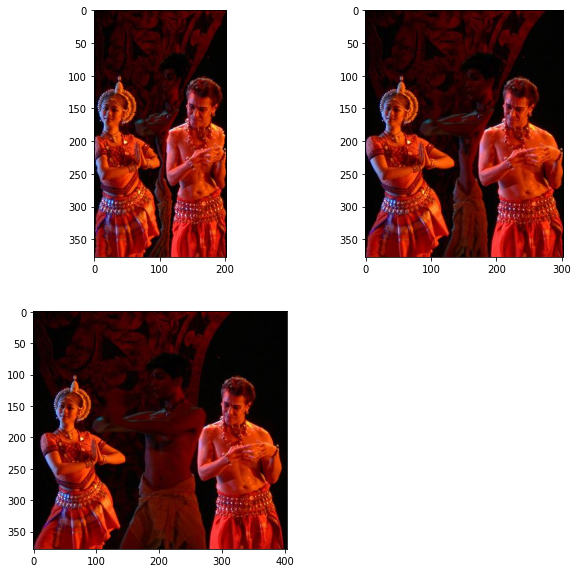

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/bangalore-dancers.jpg")

CAT

(150, 150, 3)
(150, 60, 3)
reported time for 60%= 0.07925987243652344
(150, 90, 3)
reported time for 40%= 0.05825042724609375
(150, 120, 3)
reported time for 20%= 0.03316378593444824


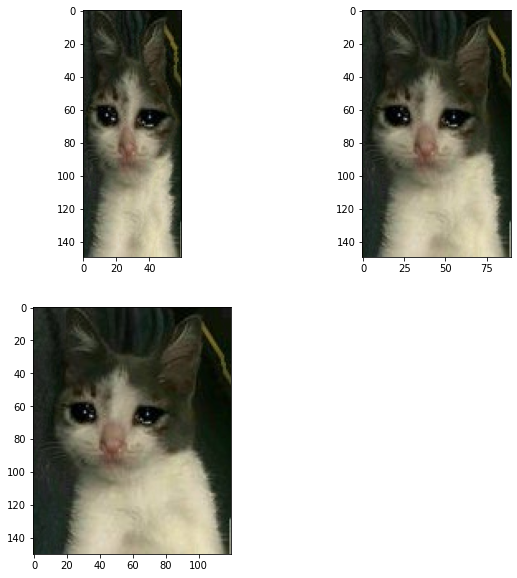

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/cat.jpg")

Chhota-bheem

(1200, 1920, 3)
(1200, 768, 3)
reported time for 60%= 112.7299394607544
(1200, 1152, 3)
reported time for 40%= 86.17052578926086
(1200, 1536, 3)
reported time for 20%= 48.854878187179565


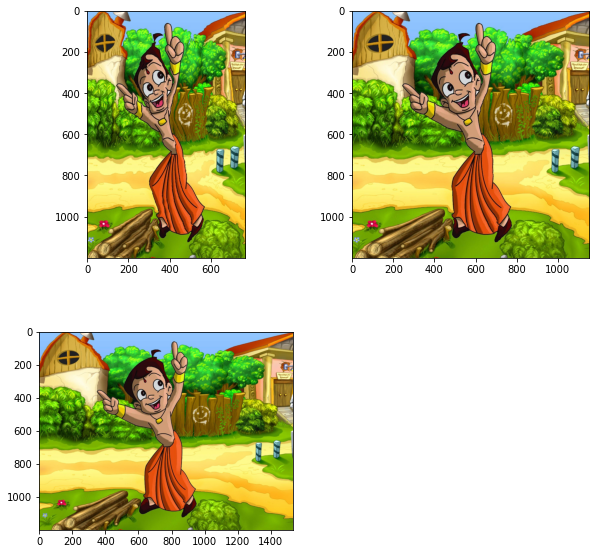

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/chhota-bheem.jpg")

iiit

(369, 880, 3)
(369, 352, 3)
reported time for 60%= 7.56740665435791
(369, 528, 3)
reported time for 40%= 5.697449684143066
(369, 704, 3)
reported time for 20%= 3.212486982345581


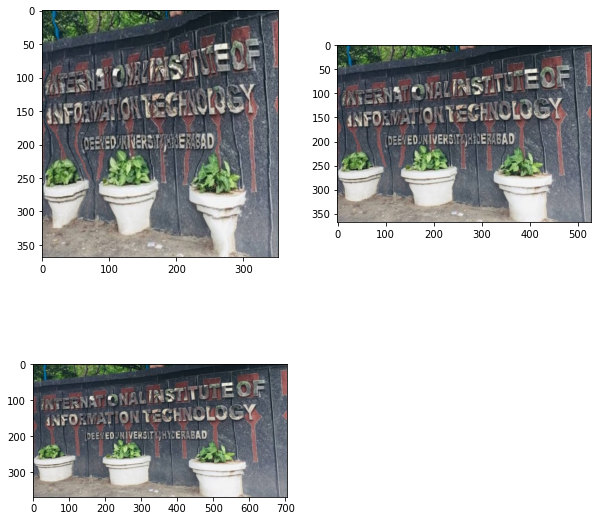

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/iiit.jpg")

Maldives

(2880, 5120, 3)
(2880, 2048, 3)
reported time for 60%= 1897.712907075882
(2880, 3072, 3)
reported time for 40%= 1480.0445320606232
(2880, 4096, 3)
reported time for 20%= 809.0133810043335


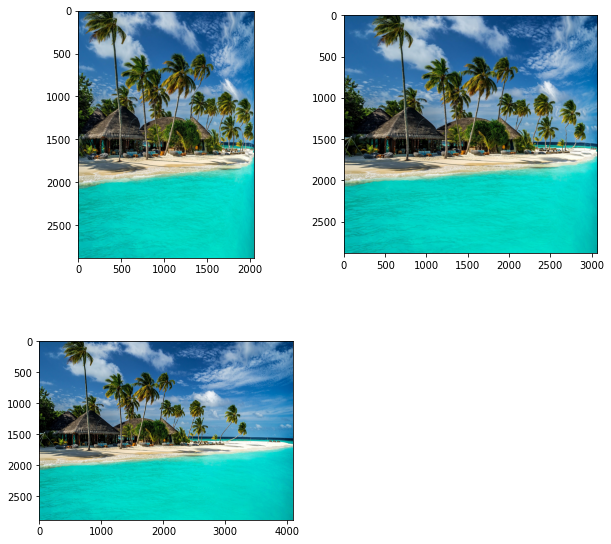

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/maldives.jpg")

Path

(500, 375, 3)
(275, 375, 3)
reported time for 60%= 2.092771530151367
(500, 375, 3)
(350, 375, 3)
reported time for 40%= 1.5327692031860352
(500, 375, 3)
(425, 375, 3)
reported time for 20%= 0.827103853225708


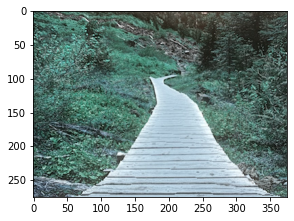

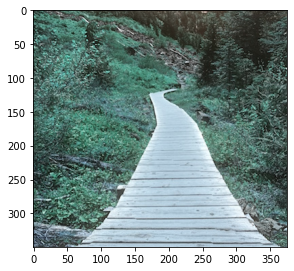

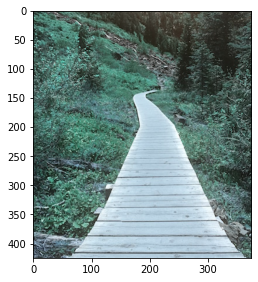

In [ ]:
#Horizontal seems
src=cv2.imread("/content/drive/MyDrive/Colab Notebooks/path.jpg")
print(src.shape)
img=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
y=src.shape[1]
(h,w,d)=src.shape
number=int((w*60)/100)
st=time.time()
img = cv2.transpose(src)
img=seam_carving(img,number)
fn=time.time()
final = cv2.transpose(img)
print(final.shape)
plt.figure(figsize=(10,10))
print("reported time for 60%=", fn-st)
plt.subplot(221)
plt.imshow(final.astype(np.uint8))

src=cv2.imread("/content/drive/MyDrive/Colab Notebooks/path.jpg")
print(src.shape)
img=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
y=src.shape[1]
(h,w,d)=src.shape
number=int((w*40)/100)
st=time.time()
img = cv2.transpose(src)
img=seam_carving(img,number)
fn=time.time()
final = cv2.transpose(img)
print(final.shape)
plt.figure(figsize=(10,10))
print("reported time for 40%=", fn-st)
plt.subplot(222)
plt.imshow(final.astype(np.uint8))

src=cv2.imread("/content/drive/MyDrive/Colab Notebooks/path.jpg")
print(src.shape)
img=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
y=src.shape[1]
(h,w,d)=src.shape
number=int((w*20)/100)
st=time.time()
img = cv2.transpose(src)
img=seam_carving(img,number)
fn=time.time()
final = cv2.transpose(img)
print(final.shape)
plt.figure(figsize=(10,10))
print("reported time for 20%=", fn-st)
plt.subplot(223)
plt.imshow(final.astype(np.uint8))

Shadow

(333, 500, 3)
(333, 200, 3)
reported time for 60%= 2.1475911140441895
(333, 300, 3)
reported time for 40%= 1.6135540008544922
(333, 400, 3)
reported time for 20%= 0.9330036640167236


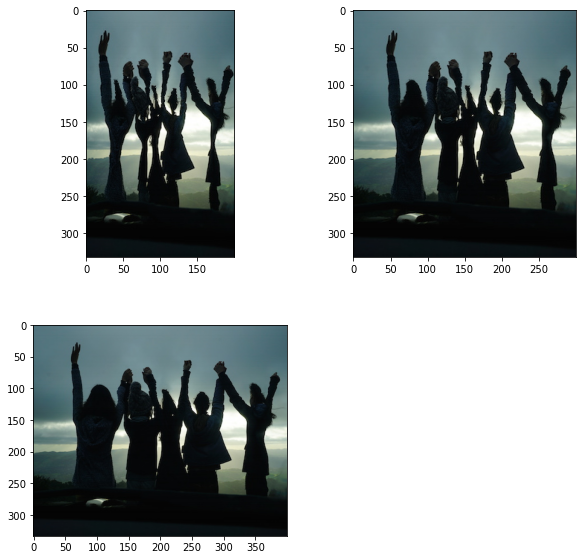

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/shadow.jpg")

Tanjore

(500, 770, 3)
(500, 308, 3)
reported time for 60%= 7.681101560592651
(500, 462, 3)
reported time for 40%= 5.890441656112671
(500, 616, 3)
reported time for 20%= 3.3616864681243896


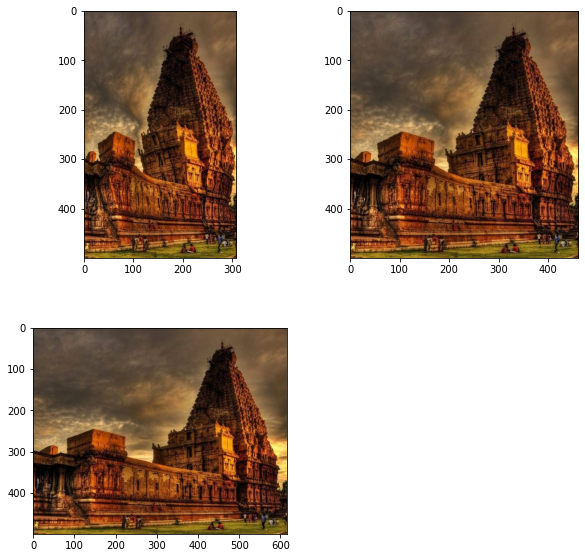

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/tanjore.jpg")

Trafalgar-square

(319, 359, 3)
(319, 144, 3)
reported time for 60%= 1.0504274368286133
(319, 216, 3)
reported time for 40%= 0.7957174777984619
(319, 288, 3)
reported time for 20%= 0.4643275737762451


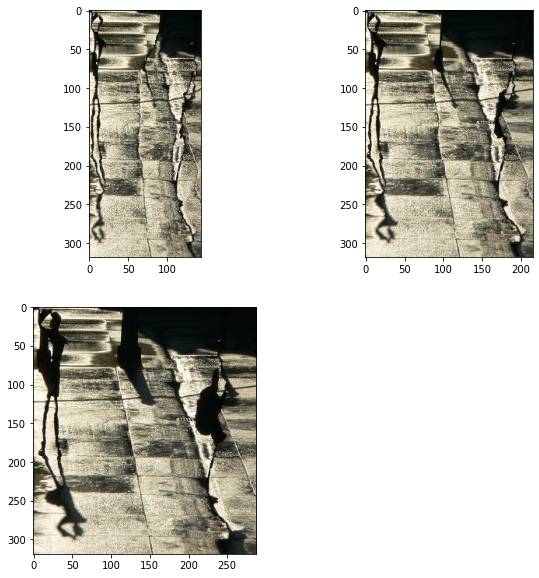

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/trafalgar-square.jpg")

Uluru

(378, 504, 3)
(378, 202, 3)
reported time for 60%= 2.3573055267333984
(378, 303, 3)
reported time for 40%= 1.7935547828674316
(378, 404, 3)
reported time for 20%= 1.0129179954528809


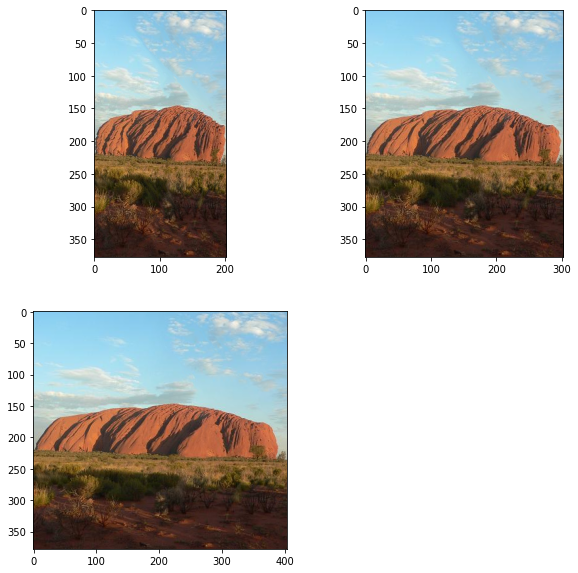

In [ ]:
percentages("/content/drive/MyDrive/Colab Notebooks/uluru.jpg")

                                                TIMINGS
                        Images |   20%    |   40%   |   60%  |
              Banglore-dancers |  1.05s   |   1.8s  |   2.3s   |
                          Cat  |  0.03s   |  0.05s  |  0.07s   |
                  Chhota-bheem |  48.8s   |  86.1s  | 112.7s   |
                        iiit   |   3.2s   |   5.6s  |   7.5s   |
                      Maldives |  809.01s | 1480.04s| 1897.71s |
                        Path   |   0.8s   |   1.5s  |  2.09s   |
                      shadow   |   0.9s   |   1.6s  |   2.1s   |
                      tanjore  |   3.3s   |   5.8s  |   7.6s   |
            Trafalgar-square   |   0.4s   |   0.7s  |   1.0s   |
                      Uluru    |   1.0s   |   1.7s  |   2.3s   |    

**Question A**

1. Seam carving function is implemented in this question. Initial we calculated seam energy first using dp. With numpy arrays each cell's energy is energy is calculated by going 1 cell above, below, up and down and then found the difference and added their squares taking square root of each cell with the current cell and then add it to particular cell energy.
2. Then, seam identification is done. The minimum element from the top row of seam energy is choosen and traversed to any of the three down side pixels. So, we reach down to last row of seam energy in (n^2)*3
3.To find the minimum seam we use a 2D array and search for the minimum element from the bottom row. And then traverse up to 1st row.
4. For the path image, I have taken the tranpose of the image and then re-transposed it after coming from final seam_carving function.

**Question B**

1. w and h are width and height of a particular image respectively. To begin with any possible seam we will have w possible options.
2. Coming down from top of the seam energy array, for each level below it as we come down we have 3 more points to check and choose the minimum seam energy and carry on. So, it is of the **O(w3^h)**. 
3. The naive solution has **O(w3^h)** and for each seam we have h size, so total time = **O(wh3^h)** for each vertical seam
4. For horizontal seam w and h will change mutually, So, the upper bound **O(h3^w)** and so for naive solution we will get **O(hw3^w)**.

**Question C**
1. If the image is flipped upside down, the output will still be the same considering np.min will give a random index if there are multiple indices with same minimum, as just the vertical seam is just inverted and nothing else changes.
2. Overall energy still remains the same. As it is just image that is turned upside down but thier calculated energies still remain same and they will adjacent to their previous cells only. So, energy remains same.
3. we should alternate between the two, that is take out 5-10 vertical seams and then switch to remove 5-10 horizontal seams. I guess this would be optimal.
4. I thought that switching between two would help us because, if we go on taking all seams in one direction, the image gets spoiled and we removed all possible low energy pixels. So, switching between the two and removing seams in both directions would be feasible.